In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [64]:
# load datasets
df= pd.read_csv('/mnt/d/LIZHI/GeneticProgramingHydrology/src(parallel_GP_exEvoProcess)/CT_CR_Latest_2/CT_Synthetic_test/weierbach.csv')

In [65]:
df.head()

,Unnamed: 0,P,E,Q,T,date
0,0,0.0,0.0,0.034238,10.250,2004-09-01 00:00:00
1,1,0.0,0.0,0.034238,9.755,2004-09-01 01:00:00
2,2,0.0,0.0,0.033817,8.930,2004-09-01 02:00:00
3,3,0.0,0.0,0.033396,8.120,2004-09-01 03:00:00
4,4,0.0,0.0,0.033396,7.555,2004-09-01 04:00:00


In [66]:
df.index= df.date.apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df.drop('date', inplace=True, axis=1)

In [67]:
df.Q[df.Q<0]=np.nan

/mnt/d/CCTV/RainfallCamera/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
df.Q= df.Q.interpolate()

In [69]:
df_daily= df.resample('1D').sum()

Text(2009-04-01 00:00:00, 20, 'validation')

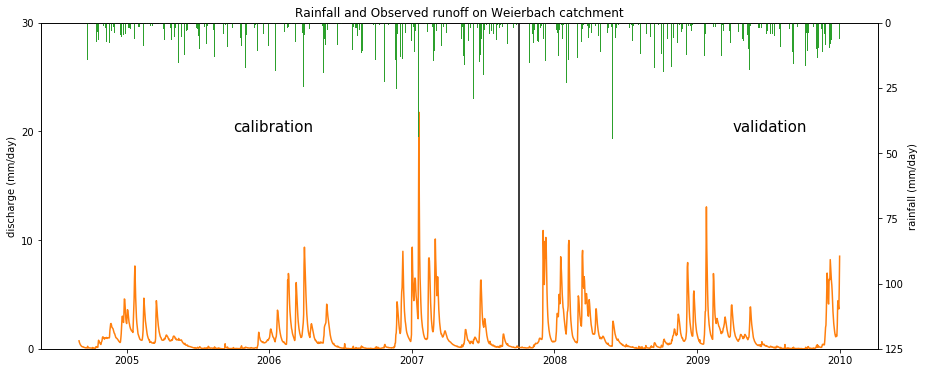

In [97]:
fig, ax= plt.subplots(1,figsize=(15,6))
ax.plot(df_daily.index, df_daily.Q, color='C1')
ax2= ax.twinx()
ax2.bar(df_daily.index, df_daily.P, color='C2')
plt.gca().invert_yaxis()
ax2.set_yticks(np.arange(0, 140,25))
ax.set_yticks(np.arange(0,40,10))
ax.set_title('Rainfall and Observed runoff on Weierbach catchment')
ax.set_ylim([0,30])
ax.set_ylabel('discharge (mm/day)')
ax2.set_ylabel('rainfall (mm/day)')
ax.vlines(datetime.datetime(2007,10,1), 0,30)
ax.text(datetime.datetime(2005,10,1),20,'calibration', fontsize=15)
ax.text(datetime.datetime(2009,4,1),20,'validation', fontsize=15)

In [72]:
df_daily.Q.max()

21.757212700000004

In [100]:
fig.savefig('hydrograph_weierbach.png', dpi=150)

In [92]:
df_training= df_daily.truncate(before=pd.Timestamp(2004,9,1), after=pd.Timestamp(2007,10,1))
df_vali= df_daily.truncate(before=pd.Timestamp(2007,10,1), after=pd.Timestamp(2009,12,31))

In [94]:
df_training.to_csv('weierbach_train_daily.csv')
df_vali.to_csv('weierbach_vali_daily.csv')

In [103]:
df.corr()

,Unnamed: 0,P,E,Q,T
Unnamed: 0,1.000000,0.027418,0.028145,0.070437,0.048040
P,0.027418,1.000000,-0.002887,0.083819,0.021628
E,0.028145,-0.002887,1.000000,-0.165391,0.607565
Q,0.070437,0.083819,-0.165391,1.000000,-0.324551
T,0.048040,0.021628,0.607565,-0.324551,1.000000


In [91]:
df_wark= pd.read_csv('wark/gen20/forcingWark.txt', skiprows=1, names=['date','Q','P','E'], sep='\t')

In [92]:
df_wark.date= df_wark.date.apply(lambda x: datetime.datetime.strptime(x,'%m %d %Y'))
df_wark.head()

,date,Q,P,E
0,2001-08-02,0.09086,1.0,4.2
1,2001-08-03,0.10281,1.5,3.8
2,2001-08-04,0.10328,1.7,3.0
3,2001-08-05,0.10178,4.9,2.9
4,2001-08-06,0.11368,7.4,3.0


In [108]:
_df= pd.read_csv('wark/gen70/NS0_Q.csv')
_df.head()
df_wark['NS0_gen70']= _df.x
_df= pd.read_csv('wark/gen70/KG10_Q.csv')
_df.head()
df_wark['KG10_gen70']= _df.x

In [94]:
Qo= np.array(sorted(df_wark.Q)[::-1])
Qm= np.array(sorted(df_wark['NS0_gen20'])[::-1])
ind= np.arange(1,len(Qo)+1)/len(Qo)
assert len(ind)==len(Qo),'len'


In [95]:
ex_ind= np.where(ind<0.02)
high_ind= np.where((ind<0.2) & (ind>0.02))
inter_ind= np.where((ind>0.2) & (ind<0.7))
low_ind= np.where((ind>0.7))

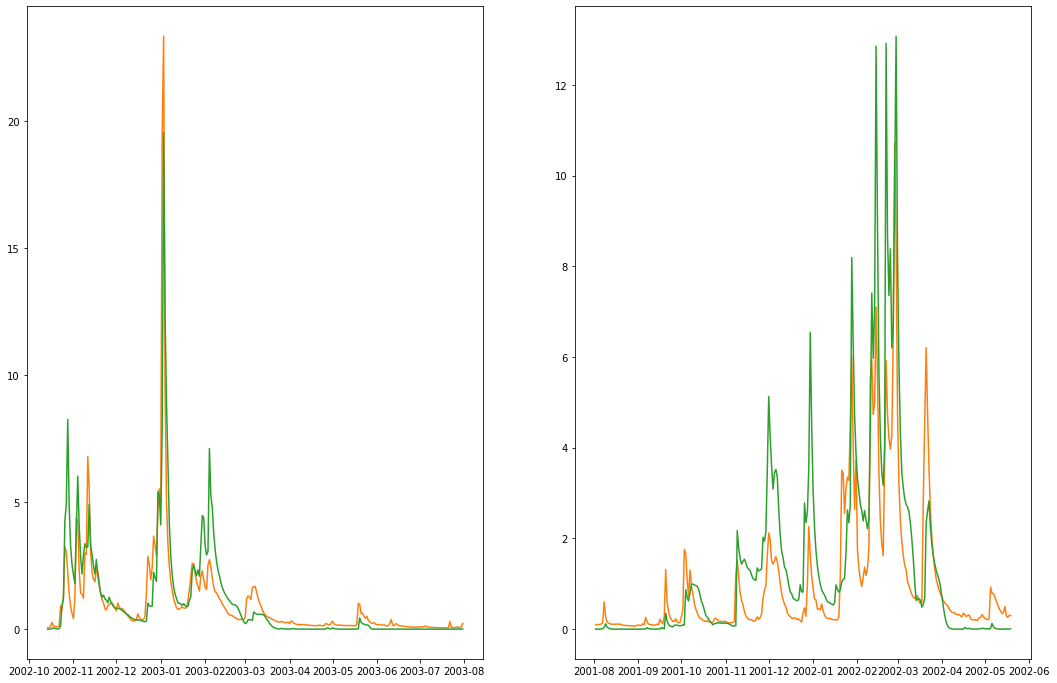

In [110]:
training= int(len(df_wark)*0.4)
fig, ax= plt.subplots(1,2, figsize=(18,12))
ax[0].plot(df_wark.date[-training:], df_wark.Q[-training:], color='C1')
ax[0].plot(df_wark.date[-training:], df_wark['KG10_gen70'][-training:], color='C2')
ax[1].plot(df_wark.date[:training], df_wark.Q[:training], color='C1')
ax[1].plot(df_wark.date[:training], df_wark['KG10_gen70'][:training], color='C2')

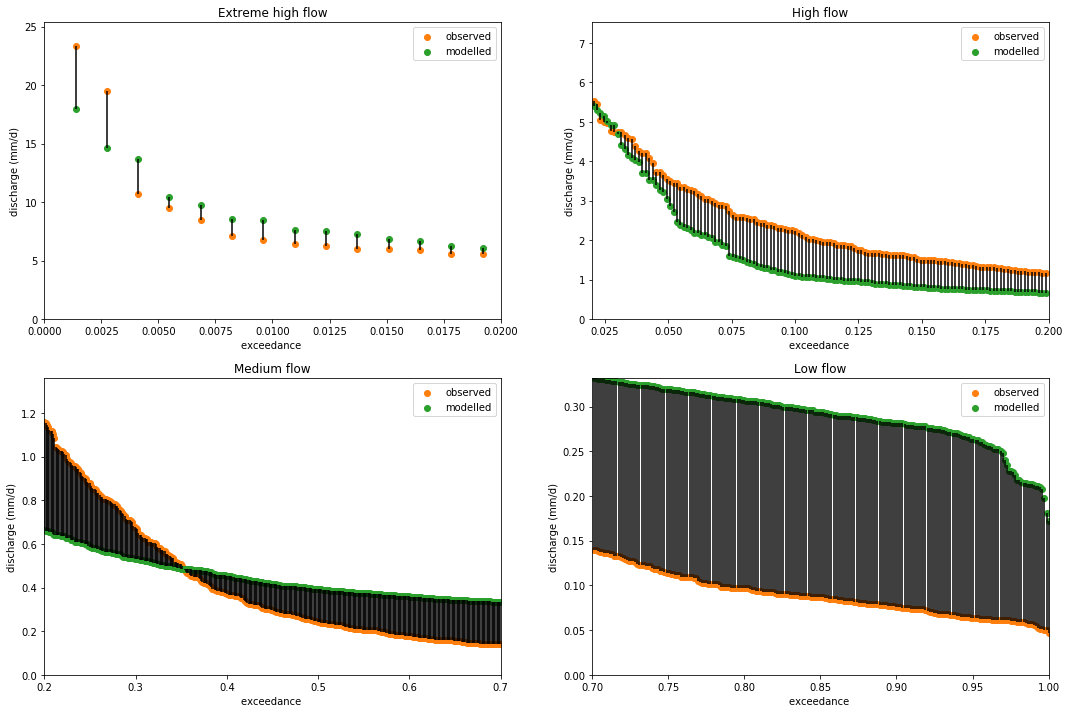

In [96]:
fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0,0].scatter(ind[ex_ind],Qo[ex_ind], color='C1', label='observed')
ax[0,0].scatter(ind[ex_ind],Qm[ex_ind], color='C2', label='modelled')
ax[0,0].vlines(ind[ex_ind], Qo[ex_ind], Qm[ex_ind])
ax[0,0].set_xlim([0,0.02])
ax[0,0].set_ylim([0,max(Qo[ex_ind].max()+2, Qm[ex_ind].max()+2)])
ax[0,0].set_ylabel('discharge (mm/d)')
ax[0,0].set_xlabel('exceedance ')
ax[0,0].set_title('Extreme high flow')
ax[0,0].legend()

ax[0,1].scatter(ind[high_ind],Qo[high_ind], color='C1', label='observed')
ax[0,1].scatter(ind[high_ind],Qm[high_ind], color='C2', label='modelled')
ax[0,1].vlines(ind[high_ind], Qo[high_ind], Qm[high_ind])
ax[0,1].set_xlim([0.02,0.2])
ax[0,1].set_ylim([0,max(Qo[high_ind].max()+2, Qm[high_ind].max()+2)])
ax[0,1].set_ylabel('discharge (mm/d)')
ax[0,1].set_xlabel('exceedance ')
ax[0,1].set_title('High flow')
ax[0,1].legend()

ax[1,0].scatter(ind[inter_ind],Qo[inter_ind], color='C1', label='observed')
ax[1,0].scatter(ind[inter_ind],Qm[inter_ind], color='C2', label='modelled')
ax[1,0].vlines(ind[inter_ind], Qo[inter_ind], Qm[inter_ind])
ax[1,0].set_xlim([0.2,0.7])
ax[1,0].set_ylim([0,max(Qo[inter_ind].max()+0.2, Qm[inter_ind].max()+0.2)])
ax[1,0].set_ylabel('discharge (mm/d)')
ax[1,0].set_xlabel('exceedance ')
ax[1,0].set_title('Medium flow')
ax[1,0].legend()

ax[1,1].scatter(ind[low_ind],Qo[low_ind], color='C1', label='observed')
ax[1,1].scatter(ind[low_ind],Qm[low_ind], color='C2', label='modelled')
ax[1,1].vlines(ind[low_ind], Qo[low_ind], Qm[low_ind])
ax[1,1].set_xlim([0.7,1])
ax[1,1].set_ylim([0,max(Qo[low_ind].max(), Qm[low_ind].max())])
ax[1,1].set_ylabel('discharge (mm/d)')
ax[1,1].set_xlabel('exceedance ')
ax[1,1].set_title('Low flow')
ax[1,1].legend()

In [77]:
fig.savefig('quantile_plot_wark.png', dpi=100)

In [85]:
df_hesperange= pd.read_csv('hesperange/gen20/data_hesperange.csv', names=['date', 'Q','P','E'], skiprows=1)
df_hesperange.date= df_hesperange.date.apply(lambda x: datetime.datetime.strptime(x,'%Y/%m/%d'))
df_hesperange.head()

,date,Q,P,E
0,2002-09-01,0.272015,0.000000,3.21172
1,2002-09-02,0.216939,0.000000,3.95574
2,2002-09-03,0.198752,2.461170,4.08765
3,2002-09-04,0.585285,3.450349,1.69436
4,2002-09-05,0.239143,0.000000,1.81287


In [86]:
_df= pd.read_csv('hesperange/gen20/NS0_Q.csv')
_df.head()
df_hesperange['NS0_gen20']= _df.x

In [87]:
Qo= np.array(sorted(df_hesperange.Q)[::-1])
Qm= np.array(sorted(df_hesperange['NS0_gen20'])[::-1])
ind= np.arange(1,len(Qo)+1)/len(Qo)
assert len(ind)==len(Qo),'len'

ex_ind= np.where(ind<0.02)
high_ind= np.where((ind<0.2) & (ind>0.02))
inter_ind= np.where((ind>0.2) & (ind<0.7))
low_ind= np.where((ind>0.7))

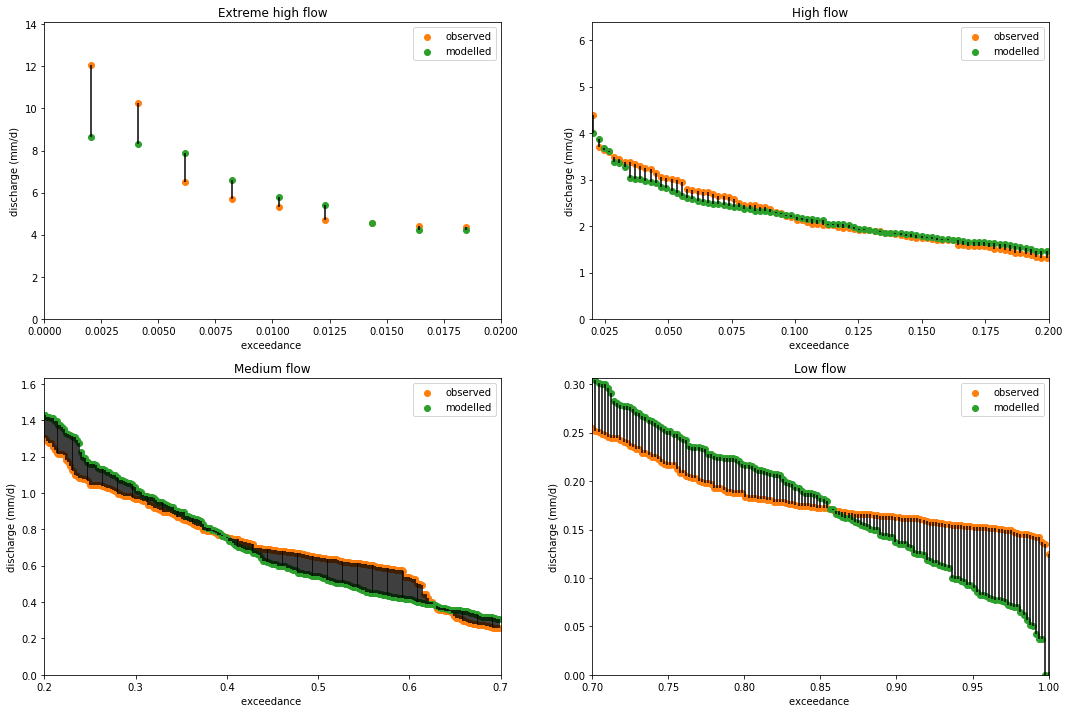

In [88]:
fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0,0].scatter(ind[ex_ind],Qo[ex_ind], color='C1', label='observed')
ax[0,0].scatter(ind[ex_ind],Qm[ex_ind], color='C2', label='modelled')
ax[0,0].vlines(ind[ex_ind], Qo[ex_ind], Qm[ex_ind])
ax[0,0].set_xlim([0,0.02])
ax[0,0].set_ylim([0,max(Qo[ex_ind].max()+2, Qm[ex_ind].max()+2)])
ax[0,0].set_ylabel('discharge (mm/d)')
ax[0,0].set_xlabel('exceedance ')
ax[0,0].set_title('Extreme high flow')
ax[0,0].legend()

ax[0,1].scatter(ind[high_ind],Qo[high_ind], color='C1', label='observed')
ax[0,1].scatter(ind[high_ind],Qm[high_ind], color='C2', label='modelled')
ax[0,1].vlines(ind[high_ind], Qo[high_ind], Qm[high_ind])
ax[0,1].set_xlim([0.02,0.2])
ax[0,1].set_ylim([0,max(Qo[high_ind].max()+2, Qm[high_ind].max()+2)])
ax[0,1].set_ylabel('discharge (mm/d)')
ax[0,1].set_xlabel('exceedance ')
ax[0,1].set_title('High flow')
ax[0,1].legend()

ax[1,0].scatter(ind[inter_ind],Qo[inter_ind], color='C1', label='observed')
ax[1,0].scatter(ind[inter_ind],Qm[inter_ind], color='C2', label='modelled')
ax[1,0].vlines(ind[inter_ind], Qo[inter_ind], Qm[inter_ind])
ax[1,0].set_xlim([0.2,0.7])
ax[1,0].set_ylim([0,max(Qo[inter_ind].max()+0.2, Qm[inter_ind].max()+0.2)])
ax[1,0].set_ylabel('discharge (mm/d)')
ax[1,0].set_xlabel('exceedance ')
ax[1,0].set_title('Medium flow')
ax[1,0].legend()

ax[1,1].scatter(ind[low_ind],Qo[low_ind], color='C1', label='observed')
ax[1,1].scatter(ind[low_ind],Qm[low_ind], color='C2', label='modelled')
ax[1,1].vlines(ind[low_ind], Qo[low_ind], Qm[low_ind])
ax[1,1].set_xlim([0.7,1])
ax[1,1].set_ylim([0,max(Qo[low_ind].max(), Qm[low_ind].max())])
ax[1,1].set_ylabel('discharge (mm/d)')
ax[1,1].set_xlabel('exceedance ')
ax[1,1].set_title('Low flow')
ax[1,1].legend()

In [89]:
fig.savefig('quantile_plot_hesperange', dpi=100)